In [46]:
from typing import TypedDict,Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
from pydantic import BaseModel,Field
import operator
import os   
load_dotenv()

True

In [38]:
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API"))

In [39]:
class EvaluationSchema(BaseModel):

    feedback:str =Field(description="Detailed Feedback on the essay")
    score:int= Field(description="Score out of 10",ge=0,le=10)

In [40]:
structured_model= model.with_structured_output(EvaluationSchema)

In [41]:
essay="""
My mother is an extraordinary woman who holds a special place in my heart. I love her deeply for countless reasons, but it’s her unwavering love and support that stand out the most. From my earliest days, she has been my biggest cheerleader, always encouraging me to pursue my dreams and believe in myself. Her love is unconditional; it envelops me like a warm blanket, providing comfort during difficult times and celebrating my successes with genuine joy.

One of the qualities I admire most about my mom is her incredible strength. She has faced numerous challenges throughout her life, yet she always manages to rise above them with grace and resilience. Whether it’s juggling work and family responsibilities or overcoming personal obstacles, she exemplifies determination and perseverance. Her ability to remain positive, even in the face of adversity, inspires me to adopt a similar mindset.

In addition to being a loving mother, she is also a companion in times of trouble. Whenever I face challenges or feel overwhelmed, she is always there to lend an ear or offer sage advice. Her wisdom and understanding create a safe space for me to express my feelings without fear of judgment. I know I can rely on her for support, whether I’m dealing with school stress or personal issues.

In conclusion, my mom is not just a parent; she is my confidante, role model, and best friend. Her love, strength, and unwavering support shape who I am today. I am eternally grateful for everything she does and for the profound impact she has on my life. I cherish our bond and look forward to creating many more beautiful memories together."""

In [42]:
prompt="Evaluate the langauge quality of the following essay  and provide a feednback and assign a score out of 10 \n{essay}"
testing=structured_model.invoke(prompt)

In [44]:
testing.feedback
testing.score

7

In [47]:
class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str

    overall_feedback: str
    individual_score:Annotated[list[int],operator.add]
    avg_score:float

In [48]:
graph=StateGraph(UPSCState)

In [49]:
def evaulate_langauge(state:UPSCState)->UPSCState:
    prompt="Evaluate the langauge quality of the following essay  and provide a feednback and assign a score out of 10 \n{essay}"
    testing=structured_model.invoke(prompt)
    # state["language_feedback"] = testing.feedback
    # state["individual_score"].append(testing.score)
    return {"language_feedback":testing.feedback,"individual_score":[testing.score]}

In [50]:
def evaluate_analysis(state:UPSCState)->UPSCState:
    prompt="Evaluate the depth of analysis of the following essay  and provide a feednback and assign a score out of 10 \n{essay}"
    testing=structured_model.invoke(prompt)
    # state["language_feedback"] = testing.feedback
    # state["individual_score"].append(testing.score)
    return {"analysis_feedback":testing.feedback,"individual_score":[testing.score]}

In [51]:
def clarity_feedback(state:UPSCState)->UPSCState:
    prompt="Evaluate the clarity of thought  of the following essay  and provide a feednback and assign a score out of 10 \n{essay}"
    testing=structured_model.invoke(prompt)
    # state["language_feedback"] = testing.feedback
    # state["individual_score"].append(testing.score)
    return {"clarity_feedback":testing.feedback,"individual_score":[testing.score]}

In [52]:
def final_evaluation(state:UPSCState)->UPSCState:

    ## summary feedback

    prompt= f"Based on the following feedback create a summarized feedback /n language feedback - {state["language_feedback"]} \n depth of analysis -{state["analysis_feedback"]} \n clarity of thought -{state["clarity_feedback"]} , provide a summary feedback and assign "
    overall_feedback= model.invoke(prompt).content


    ## average score
    avg_score=sum(state["individual_score"])/len(state["individual_score"])


    return {"overall_feedback":overall_feedback,"avg_score":avg_score}

In [53]:
graph.add_node("evaluate_langauge",evaulate_langauge)
graph.add_node("evaluate_analysis",evaluate_analysis)
graph.add_node("clarity_feedback",clarity_feedback)
graph.add_node("final_evaluation",final_evaluation)



## edges 

graph.add_edge(START,"evaluate_langauge")
graph.add_edge(START,"evaluate_analysis")
graph.add_edge(START,"clarity_feedback")


graph.add_edge("evaluate_langauge","final_evaluation")
graph.add_edge("evaluate_analysis","final_evaluation")
graph.add_edge("clarity_feedback","final_evaluation")

graph.add_edge("final_evaluation",END)

In [54]:
workflow=graph.compile()

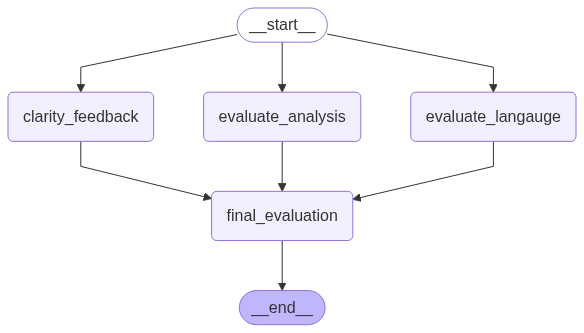

In [55]:
workflow

In [57]:
inital_state={"essay":essay}
workflow.invoke(inital_state)


{'essay': '\nMy mother is an extraordinary woman who holds a special place in my heart. I love her deeply for countless reasons, but it’s her unwavering love and support that stand out the most. From my earliest days, she has been my biggest cheerleader, always encouraging me to pursue my dreams and believe in myself. Her love is unconditional; it envelops me like a warm blanket, providing comfort during difficult times and celebrating my successes with genuine joy.\n\nOne of the qualities I admire most about my mom is her incredible strength. She has faced numerous challenges throughout her life, yet she always manages to rise above them with grace and resilience. Whether it’s juggling work and family responsibilities or overcoming personal obstacles, she exemplifies determination and perseverance. Her ability to remain positive, even in the face of adversity, inspires me to adopt a similar mindset.\n\nIn addition to being a loving mother, she is also a companion in times of trouble. 